In [1]:
import os
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

from collections import Counter # for mAP

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import cv2

# Folders

In [3]:
ds_dir = 'ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels - copia.cache', 'labels.cache', 'labels', 'images']
val dir: ['labels.cache', 'labels', 'labels_2.cache', 'images']


# Config

In [4]:
CLASSES = ["smoke", "fire"]
#CLASSES = ["cat", "dog"]

#IMG_DIM = {'W':88, 'H':88} # (W, H)
#IMG_DIM = {'W':160, 'H':120} # (W, H)
#IMG_DIM = {'W':448, 'H':448} # (W, H)
IMG_DIM = {'W':224, 'H':224} # (W, H)

SX = 7
SY = 7
B = 1 # Number of bounding boxes to predict.
C = len(CLASSES) # Number of classes in the dataset.

# Utils

In [5]:
def yolo2pixel(bbox):
    '''
    Transforms yolo coordinates of the box to pixel coordinates. 
    
    Arguments:
        - bbox: yolo coordinates [xc, yc, width, height]
    
    Returns: 
        - pixel coordinates [xmin, xmax, ymin, ymax]
    '''
    xc = bbox[0]
    yc = bbox[1]
    width = bbox[2]
    height = bbox[3]
      
    xmin = xc - (width/2)          
    xmax = xc + (width/2)         
    ymin = yc - (height/2)            
    ymax = yc + (height/2)
        
    nbox = [xmin, ymin, xmax, ymax]
    
    return nbox


def iou_tensor(
    boxes_preds, boxes_labels, 
    box_format="midpoint",
    epsilon=1e-6
):
    """
    Calculates intersection over union for bounding boxes.
    
    :param boxes_preds (tensor): Bounding box predictions of shape (BATCH_SIZE, 4)
    :param boxes_labels (tensor): Ground truth bounding box of shape (BATCH_SIZE, 4)
    :param box_format (str): midpoint/corners, if boxes (x,y,w,h) format or (x1,y1,x2,y2) format
    :param epsilon: Small value to prevent division by zero.
    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == 'midpoint':
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == 'corners':
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4] 
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = (box1_area + box2_area - intersection + epsilon)

    iou = intersection / union
    #print(f'IOU is numpy: {iou.numpy()}')

    return iou

def nms_yv1(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [x1, y1, x2, y2, confidence, class_id] MY FORMAT VERSION       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[4] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[4], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[5] != chosen_box[5]
            or iou_tensor(
                torch.tensor(chosen_box[:4]),
                torch.tensor(box[:4]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

def nms_yv1_getBBoxes(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_id, score, xc, yc, w, h] Output of outcell_2_outboxes       
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or iou_tensor(
                torch.tensor(chosen_box[2:6]),
                torch.tensor(box[2:6]),
                box_format=box_format,
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms



def mAP(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=2
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []
    avg_prec = {}

    # Precision and Recall for each class
    cls_prec = {}
    cls_rec = {}

    # used for numerical stability later on
    epsilon = 1e-6

    #for c in range(num_classes):
    for c in tqdm(range(num_classes), desc ="mAP:@.5"):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        
        #print(f'Detections of class {c}: {detections}')
        
        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        
        #print(f'Amount bboxes of class {c}: {amount_bboxes}')

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        #print(f'Amount bboxes of class {c} converted: {amount_bboxes}')
        
        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
       
        #print(f'Total true bboxes of class {c}: {total_true_bboxes}')
        
        # If none exists for this class then we can safely skip
        # Maybe removing this is enough to take into account False Positives
        # for images with no objects
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = iou_tensor(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )
                # iou, _, _ = ut.iou(detection[3:], 
                #                    gt[3:]) 

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #print(f'True Positives class {c}: {TP}')
        #print(f'False Positives class {c}: {FP}')

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)

        if precisions.numel() > 0:
            #cls_prec.update({c: precisions[-1].numpy()})
            cls_prec.update({c: precisions[-1].item()})
        else:
            cls_prec.update({c: 0.})
        if recalls.numel() > 0:
            #cls_rec.update({c: recalls[-1].numpy()})
            cls_rec.update({c: recalls[-1].item()})
        else:
            cls_rec.update({c: 0.})

        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))
        avg_prec.update({c: torch.trapz(precisions, recalls)})

    mAP = sum(average_precisions) / (len(average_precisions) + epsilon)

    #return mAP, average_precisions, cls_prec, cls_rec
    return (mAP, 
            avg_prec,
            cls_prec, 
            cls_rec)


def get_bboxes(
    loader,
    model,
    SX,
    SY,
    B,
    C,
    mask,
    iou_threshold,
    threshold,
    device,
    box_format="midpoint"):
    
    
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    #for batch_idx, (imgs, labels, _, _) in enumerate(loader):
    for batch_idx, (imgs, labels) in enumerate(loader):
        imgs = imgs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(imgs)

        batch_size = imgs.shape[0]
        true_bboxes = outcell_2_outboxes(out_cells=labels, 
                                         SX=SX, SY=SY, B=B, C=C, 
                                         mask=mask, 
                                         device='cpu', # Changed to cpu
                                         is_pred=False)
        bboxes = outcell_2_outboxes(out_cells=predictions, 
                                    SX=SX, SY=SY, B=B, C=C, 
                                    mask=mask, 
                                    device='cpu', # Changed to cpu
                                    is_pred=True)

        for idx in range(batch_size):
            #nms_boxes = nms_yv1(
            nms_boxes = nms_yv1_getBBoxes(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format, # Midpoint, to use iou_tensor inside
            )


            #if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


def outcell_2_outboxes(out_cells, SX, SY, B, C, mask, device, is_pred = True):
    '''
    Convert batch of cells to batch of boxes: out_cells must be of shape (BATCH_SIZE, SX, SY, B*5+C) 
        [xcel, ycel, w, h, conf, class_0, class_1] -> [pred_class, score, xc, yc, w, h]
    
    Arguments:
        - out_cells: labels at loader output or predictions at model output
            Format: [xcel, ycel, w, h, conf, class_0, class_1]
    Return:
        - all_bboxes: list of bounding boxes
            Format: [[bboxes idx 0], [bboxes idx 1], ... [bboxes idx BATCH_SIZE-1]]
    '''

    out_cells = out_cells.to(device) # TAKE A LOOK TO CPU DECISION

    out_cells[out_cells <= 0] = 0 # Zeroing all negative values. Avoid (-conf * -class_id) = +score
    #out_cells[out_cells >= 1] = 1 # Clamping all values to 1. Avoid being out of the image. Maybe afterwards, although it does not hurt here.
                                   # This is due to yolo2pixel transformation, which could led to out of image values, depending on (w, h)

    batch_size = out_cells.shape[0]
    if is_pred:
        out_cells = out_cells.reshape(batch_size, SY, SX, B*5+C)
    else:
        out_cells = out_cells.reshape(batch_size, SY, SX, 5+C)
    
    # With 2 BBoxes, choose the one with highest confidence. How highest IOU, without label?
    if (B>1 and is_pred):
        '''
        2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
        '''
        bbox1 = out_cells[..., :4]
        bbox2 = out_cells[..., 5:9]
        score = torch.cat((out_cells[..., 4:5],out_cells[..., 9:10]), dim=-1)
        best_score, idx = torch.max(score, dim=-1, keepdim=True)

        bestbbox = (1-idx)*bbox1 + idx*bbox2

        #class_prob = a[..., 10:12] # Esto no hace falta, se hace debajo
        #cls_pred = class_prob.argmax(dim=-1, keepdim=True)
        out_cells = torch.cat((bestbbox, best_score, out_cells[..., 10:12]), dim=-1)
        
    
    # All cells are converted to boxes. Format will be [xc, yc, w, h, conf, class_0, class_1]
    boxes = cell2boxes(cells = out_cells, mask = mask)

    # ================================================================================================================== #
    #                                                                                                                    #
    #     Convert [xc, yc, w, h, conf, class_0, class_1] to [pred_class, score, xc, yc, w, h]                            #
    #         Identify class predicted: class_0 > class_1 ??? or the opposite                                            #
    #         Multiply (conf * class_id) to get score and compare to threshold afterwards. It will be 1 for ground truth #
    #                                                                                                                    #
    # ================================================================================================================== #
    classes = boxes[...,5:7].argmax(-1).unsqueeze(-1) # Indices of class predictes, matching class_id: index 0 -> smoke, class id = 0 // same for fire
    #print(f'Tensor of classes predicted\n {classes}')   
    
    scores = ( boxes[...,4].unsqueeze(-1) ) * boxes[...,5:7] # score = confidence * [class_0_prob, class_1_prob]
    scores, _ = torch.max(scores, dim=-1, keepdim=True) # Get maximum values -> score of class predicted
    #print(f'Scores together\n {scores}')     
    
    out_boxes = torch.concat((classes, scores, boxes[...,:4]), dim=-1) # Concat all data
    #print(f'Final Output {out_boxes}')    

    # =========================================== #
    #                                             #
    #             Convert boxes to List           #
    #                                             #
    #    [[bboxes idx 0] , [bboxes idx 1], etc]   #
    #                                             #
    # =========================================== #
    all_bboxes = []

    for ex_idx in range(batch_size):
        bboxes = []

#         for bbox_i in range(SX):
#             for bbox_j in range(SY):
#                 bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_i, bbox_j, :]])
        for bbox_i in range(SX):
            for bbox_j in range(SY):
                bboxes.append([x.item() for x in out_boxes[ex_idx, bbox_j, bbox_i, :]])     
        all_bboxes.append(bboxes)
    
    return all_bboxes


def cell2boxes(cells, mask):
    '''
    Converts cells to boxes using the cell2box_mask and broadcasting over batches
    In targets, sum only when score = 1

    Arguments:
        - cells: cells to convert, as yield by Dataloader in batches
        - mask: mask used for conversion

    Return:
        - cells converted to boxes
    '''

    #out_boxes = cells.clone().detach()
    out_boxes = cells.detach().clone()
    out_boxes[...,0:1] = (out_boxes[...,0:1] + mask[...,0:1])/SX 
    out_boxes[...,1:2] = (out_boxes[...,1:2] + mask[...,1:2])/SY 

    return out_boxes


def plot_preds(ori_img, img_w, img_h, nms_preds, names, colors):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''
    
    pic = ori_img.copy()
    
    for i,(xc,yc,w,h,score,class_id) in enumerate(nms_preds):
        box = np.array(yolo2pixel([xc,yc,w,h]))
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w
        box[3] = box[3]*img_h
        box = box.round().astype(np.int32).tolist()
        cls_id = int(class_id)
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic,box[:2],box[2:],color,2) # 1 -> rectangle thickness
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],thickness=1)  # 0.5 -> font size

    return pic

def save_log(epochs, 
             train_total_loss,
             train_box_loss,
             train_class_loss,
             train_confidence_loss,
             train_noobj_loss,
             train_mAP,
             train_class_AP,
             train_class_precision,
             train_class_recall,
             val_total_loss,
             val_box_loss,
             val_class_loss,
             val_confidence_loss,
             val_noobj_loss,
             val_mAP,
             val_class_AP,
             val_class_precision,
             val_class_recall,
             log_file_dst):
    
    '''
    Create a dictionary with all metrics
    Save the dictionary as excel file with Pandas
    '''
    
    epoch_range = range(epochs)
    log_file = {}
    log_file.update({"epoch": epoch_range})
    
    # Train Losses
    log_file.update({"train_total_loss": train_total_loss})
    log_file.update({"train_box_loss": train_box_loss})
    log_file.update({"train_class_loss": train_class_loss})
    log_file.update({"train_confidence_loss": train_confidence_loss})
    log_file.update({"train_noobj_loss": train_noobj_loss})
    
    # Train mAP, Class AP, Precision, Recall
    train_mAP_log = []
    for e in train_mAP:
        #train_mAP_log.append(e.numpy())
        #train_mAP_log.append(e)
        train_mAP_log.append(e.item())
    log_file.update({"train_mAP": train_mAP_log})
    
    train_smk_AP = []
    train_fire_AP = []
    for e in train_class_AP:
        #train_smk_AP.append(e[0].numpy())
        #train_smk_AP.append(e[0])
        train_smk_AP.append(e[0].item())
        #train_fire_AP.append(e[1].numpy())
        #train_fire_AP.append(e[1])
        train_fire_AP.append(e[1].item())
    log_file.update({"train_smk_AP": train_smk_AP})
    log_file.update({"train_fire_AP": train_fire_AP})
    
    
    train_smk_precision = []
    train_fire_precision = []
    for e in train_class_precision:
        #train_smk_precision.append(e[0].numpy())
        train_smk_precision.append(e[0])
        #train_fire_precision.append(e[1].numpy())
        train_fire_precision.append(e[1])
    log_file.update({"train_smk_precision": train_smk_precision})
    log_file.update({"train_fire_precision": train_fire_precision})
        
    train_smk_recall = []
    train_fire_recall = []
    for e in train_class_recall:
        #train_smk_recall.append(e[0].numpy())
        train_smk_recall.append(e[0])
        #train_fire_recall.append(e[1].numpy())
        train_fire_recall.append(e[1])
    log_file.update({"train_smk_recall": train_smk_recall})
    log_file.update({"train_fire_recall": train_fire_recall})
    
    # Validation Losses
    log_file.update({"val_total_loss": val_total_loss})
    log_file.update({"val_box_loss": val_box_loss})
    log_file.update({"val_class_loss": val_class_loss})
    log_file.update({"val_confidence_loss": val_confidence_loss})
    log_file.update({"val_noobj_loss": val_noobj_loss})
    
    # Val mAP, Class AP, Precision, Recall
    val_mAP_log = []
    for e in val_mAP:
        #val_mAP_log.append(e.numpy())
        val_mAP_log.append(e.item())
    log_file.update({"val_mAP": val_mAP_log})
    
    val_smk_AP = []
    val_fire_AP = []
    for e in val_class_AP:
        val_smk_AP.append(e[0].item())
        val_fire_AP.append(e[1].item())
    log_file.update({"val_smk_AP": val_smk_AP})
    log_file.update({"val_fire_AP": val_fire_AP})
    
    val_smk_precision = []
    val_fire_precision = []
    for e in val_class_precision:
        val_smk_precision.append(e[0])
        val_fire_precision.append(e[1])
    log_file.update({"val_smk_precision": val_smk_precision})
    log_file.update({"val_fire_precision": val_fire_precision})
    
    val_smk_recall = []
    val_fire_recall = []
    for e in val_class_recall:
        val_smk_recall.append(e[0])
        val_fire_recall.append(e[1])
    log_file.update({"val_smk_recall": val_smk_recall})
    log_file.update({"val_fire_recall": val_fire_recall})
    
    df = pd.DataFrame(log_file)
    df.to_excel(log_file_dst)

# Dataset

# DFire

In [6]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, 
                 SX, SY, C, 
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.SX = SX
        self.SY = SY
        self.C = C
        self.transform = transform
        self.target_transform = target_transform

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xc, yc, w, h = bbox[0], bbox[1], bbox[2], bbox[3]
        xmin = xc - w/2
        ymin = yc - h/2
        xmax = xc + w/2
        ymax = yc + h/2
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_mtx = np.zeros((self.SY, self.SX))
                overlapping_object = 0

                one_bboxes = []
                one_labels = []
            
                with open(label) as f:
                    lines = f.readlines()
                    for line in lines:
                        class_id, x, y, w, h = line.strip().split()
                        class_id = int(class_id)
                        box = np.array([x, y, w, h]).astype(np.float32)
                        x, y, w, h = box[0], box[1], box[2], box[3]
                        box_ok = self.__bbox_check__([x, y, w, h])
                        x, y, w, h = box_ok[0], box_ok[1], box_ok[2], box_ok[3]
                        i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                        if label_mtx[i, j] == 1:
                            overlapping_object = 1
                            overlapping_rem += 1
                            #print(f'Removed {label} due to overlapping object in cell {i, j}')
                            break
                        else:
                            label_mtx[i, j] = 1
                            one_bboxes.append([x, y, w, h])
                            # smoke
                            if class_id == 0:
                                one_labels.append(0)
                            # fire
                            elif class_id == 1:
                                one_labels.append(1)
                            else:
                                print(f'File {label} errored in cell {i, j}')

                    if overlapping_object == 0:
                        # Padding to SX*SY labels and bounding boxes, so you can store tensors
                        # Label -1 indicates no box
                        for idx in range(self.SX*self.SY - len(one_labels)):
                            one_bboxes.append([0, 0, 0, 0])
                            one_labels.append(-1)
                        # print(f'\nBboxes and Labels of image {image_path}')
                        # print("Bboxes")
                        # for box in one_bboxes:
                        #     print(box)
                        # print("Labels")
                        # for label in one_labels:
                        #     print(label)
                        bboxes.append(one_bboxes)
                        labels.append(one_labels)
                        images.append(image_path)
        
        print(f'Removed wrong images: {wrong_imgs}')
        print(f'Removed due to overlapping: {overlapping_rem}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels

    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = img / 255.
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# DFS

In [7]:
dfs_base_dir = 'ds2fire/dfs_xml/'
dfs_images_dir = dfs_base_dir + 'images/'
dfs_labels_dir = dfs_base_dir + 'labels/'


# Get all txt file paths in path_annot and sort them
dfs_xml_files = sorted(
    [
        os.path.join(dfs_labels_dir, file_name)
        for file_name in os.listdir(dfs_labels_dir)
        if file_name.endswith(".xml")
    ]
)

dfs_len = len(dfs_xml_files)
dfs_train_elements = int(dfs_len*0.8)
dfs_test_elements = dfs_len - dfs_train_elements

random.shuffle(dfs_xml_files)
dfs_train_list = dfs_xml_files[:dfs_train_elements]
dfs_test_list = dfs_xml_files[dfs_train_elements:]

print(f'DFS number of samples: {dfs_len}')
print(f'DFS train samples: {len(dfs_train_list)}')
print(f'DFS test samples: {len(dfs_test_list)}')


DFS number of samples: 9462
DFS train samples: 7569
DFS test samples: 1893


In [8]:
class DFSDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - SX:               number of cells in X axis (horizontal -> width)
        - SY:               number of cells in Y axis (vertical -> height)
        - C:                number of classes, 2 in this case
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded
    '''

    def __init__(self, img_h, img_w, img_dir, labels_list, 
                 SX, SY, C, 
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.labels_list = labels_list
        self.SX = SX
        self.SY = SY
        self.C = C
        self.transform = transform
        self.target_transform = target_transform
        
        self.images, self.bboxes, self.labels = self.__build_ds__(self.labels_list)
        
        self.num_samples = self.images.shape[0]

    def __len__(self):
        return self.num_samples
    
    def __bbox_check__(self, bbox):
        eps = 1e-6
        
        xmin, ymin, xmax, ymax = bbox[0], bbox[1], bbox[2], bbox[3]
        
        xmin = max(xmin, 0 + eps)
        ymin = max(ymin, 0 + eps)
        xmax = min(xmax, 1)
        ymax = min(ymax, 1)
        
        bbox = np.array([ 
                (xmin+xmax)/2,
                (ymin+ymax)/2,
                xmax-xmin,
                ymax-ymin
                 ]).astype(np.float32)
        
        return bbox        


    def __build_ds__(self, labels_list):
        bboxes = []
        labels = []
        images = []
        wrong_imgs = 0
        overlapping_rem = 0
        
        for xml_file in labels_list:
#             fname = Path(xml_file).stem
#             image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
            
            tree = ET.parse(xml_file)
            root = tree.getroot()

            image_name = root.find("filename").text
            image_path = os.path.join(self.img_dir, image_name)
            #print(image_name, image_path)
            
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                overlapping_object = 0

                label_mtx = np.zeros((self.SY, self.SX))

                size = root.find("size")
                img_w = float(size.find("width").text)
                img_h = float(size.find("height").text)

                one_bboxes = []
                one_labels = []

                for obj in root.iter("object"):
                    class_name = obj.find("name").text
                    if class_name == 'smoke':
                        class_id = 0
                    elif class_name == 'fire':
                        class_id = 1
                    else:
                        continue 
                    bbox = obj.find("bndbox")
                    xmin = float(bbox.find("xmin").text)/img_w
                    ymin = float(bbox.find("ymin").text)/img_h
                    xmax = float(bbox.find("xmax").text)/img_w
                    ymax = float(bbox.find("ymax").text)/img_h

                    box = self.__bbox_check__([xmin, ymin, xmax, ymax])
                    #print(f'Class: {class_name} - Class_id: {class_id}. Coords: x={x}, y={y}, w={w}, h={h}')

                    x, y, w, h = box[0], box[1], box[2], box[3]
                    i, j = math.floor(y * self.SY), math.floor(x * self.SX)
                    if label_mtx[i, j] == 1:
                        overlapping_object = 1
                        overlapping_rem += 1
                        break
                    else:
                        label_mtx[i, j] = 1
                        one_bboxes.append([x, y, w, h])
                        # smoke
                        if class_id == 0:
                            one_labels.append(0)
                        # fire
                        elif class_id == 1:
                            one_labels.append(1)
                        else:
                            print(f'File {label} errored in cell {i, j}') 

                if overlapping_object == 0:
                    # Padding to SX*SY labels and bounding boxes, so you can store tensors
                    # Label -1 indicates no box
                    for idx in range(self.SX*self.SY - len(one_labels)):
                        one_bboxes.append([0, 0, 0, 0])
                        one_labels.append(-1)
                    # print(f'\nBboxes and Labels of image {image_path}')
                    # print("Bboxes")
                    # for box in one_bboxes:
                    #     print(box)
                    # print("Labels")
                    # for label in one_labels:
                    #     print(label)
                    bboxes.append(one_bboxes)
                    labels.append(one_labels)
                    images.append(image_path)

        print(f'Removed wrong images: {wrong_imgs}')
        print(f'Removed due to overlapping: {overlapping_rem}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        bboxes_np = np.array(bboxes)
        bboxes_tensor = torch.tensor(bboxes_np, dtype=torch.float32)
        images_array = np.array(images)
        # print(f'Images array {images_array}')
        # print(f'Bboxes tensor {bboxes_tensor}')
        # print(f'Labels tensor {labels_tensor}')
        
        return images_array, bboxes_tensor, labels_tensor
        #return images, bboxes, labels


 
    def __getitem__(self, index):

        # Image processing
        img_file = self.images[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   
        #img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)

        # Labels processing
        bboxes = self.bboxes[index]
        bboxes = bboxes[~torch.all(bboxes == torch.tensor([0,0,0,0]), dim=1)]
        bboxes = bboxes.numpy().tolist()
        #print(bboxes)
        labels = self.labels[index]
        labels = labels[labels != -1.]
        labels = labels.numpy().tolist()
        #print(f'Labels inside dataset {labels}')
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img, bboxes=bboxes, class_labels=labels)
                img = aug['image']
                bboxes = aug['bboxes']
                labels = aug['class_labels']
            except:
                #print(f'Error trying to augment image {img_file}')
                img = cv2.resize(img, (self.img_w, self.img_h), interpolation = cv2.INTER_NEAREST)
                img = img / 255.
                img = torch.tensor(img, dtype=torch.float32)
                img = img.permute(2, 0, 1)
        
        label_mtx = np.zeros((self.SY, self.SX, 5+self.C))
        
        for box, label in zip(bboxes, labels):
            class_id = int(label)
            i, j = int(box[1]*self.SY), int(box[0]*self.SX)
            xcell, ycell = box[0]*self.SX - j, box[1]*self.SY - i
            label_mtx[i, j, :5] = [xcell, ycell, box[2], box[3], 1]
            label_mtx[i, j, 5+class_id] = 1

        label_mtx = torch.tensor(label_mtx, dtype=torch.float32)
        
        #return img, label_mtx, img_file
        return img, label_mtx

# Visualize some examples with a Test Train Loader

In [11]:
view_dir = 'dfire4ex/train/'

view_train_imgs = view_dir + 'images/'
view_train_labels = view_dir + 'labels/'

In [18]:
VIEW_BATCH_SIZE = 16
VIEW_NUM_WORKERS = 1
VIEW_PIN_MEMORY = True

VIEW_S = 7
VIEW_C = 2
VIEW_B = 1

VIEW_IMG_W = 224
VIEW_IMG_H = 224

# Data Aug Function

In [12]:
view_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomSizedBBoxSafeCrop(height=int(1.4*VIEW_IMG_H),
                              width= int(1.4*VIEW_IMG_W),
                              erosion_rate=0.6,
                              p=0.3),
    A.HueSaturationValue(hue_shift_limit=10, p=0.2),
    A.Blur(blur_limit=(3,3), p=0.2),
    A.CLAHE(clip_limit=2.0, p=0.3),
    # Shifting, scaling and rotation could dive 2 bbox inside same grid...
    #A.ShiftScaleRotate(rotate_limit=5, p=0.2),
    A.Resize(VIEW_IMG_H, VIEW_IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
    ToTensorV2(p=1),
], bbox_params=A.BboxParams(format='yolo', 
                            #min_area=6*6, 
                            #min_visibility=0.05, 
                            label_fields=['class_labels']))


# DFS Dataset

In [13]:
view_dfs_dataset = DFSDataset(img_h = VIEW_IMG_H,
                              img_w = VIEW_IMG_W,
                              img_dir = dfs_images_dir,
                              labels_list = dfs_test_list,
                              SX = VIEW_S,
                              SY = VIEW_S,
                              C = VIEW_C,
                              transform=view_transform)

Removed wrong images: 0
Removed due to overlapping: 47


# View Loader

In [19]:
view_loader = DataLoader(dataset=view_dfs_dataset,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=VIEW_NUM_WORKERS,
                         pin_memory=VIEW_PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

# Utils to Plot

In [15]:
def get_bboxes_from_label_mtx(label_mtx):

    c2b_mtx = np.zeros((VIEW_S, VIEW_S, 2))
    for j in range(VIEW_S):
        for i in range(VIEW_S):
            c2b_mtx[i, j, 0] = j
            c2b_mtx[i, j, 1] = i

    label_mtx = label_mtx.numpy()
    label_xy = label_mtx[..., :2]
    label_rest = label_mtx[..., 2:]

    c2b_xy = (c2b_mtx+label_xy)/VIEW_S
    out = np.concatenate((c2b_xy, label_rest), axis=-1)
    #print(f'Concat out\n {out}')

    bboxes_list = np.reshape(out, (VIEW_S*VIEW_S, 5+VIEW_C))

    bboxes_list = [bbox for bbox in bboxes_list.tolist() if bbox[4]==1]

    return bboxes_list


def plot_pytorch(ds_img, img_w, img_h, nms_preds):
    '''
    It draws the bounding boxes over the image.

    Arguments:
        - ori_img: original image with no modification or letterbox
        - nms_preds: Non Maximum Supression predictions [x0, y0, x1, y1, class_id, score]
        - names: list of class names
        - colors: list of colors asigned to each class in cv2 format (B,G,R)
        - ratio: ratio of letterbox conversion
        - dwdh: paddings of letterbox conversion

    Returns:
        - pic: picture with bounding boxes on top of original picture
    '''

    names ={0: 'smoke', 1: 'fire'}
    colors = {'smoke': (0,255,255), 'fire': (255,255,0)}
    # NEVER remove copy() or use np.ascontiguousarray()
    pic = ds_img.numpy().copy()       

    for i,(xc,yc,w,h,score,smoke,fire) in enumerate(nms_preds):
        xmin, ymin, xmax, ymax = xc - w/2, yc - h/2, xc + w/2, yc + h/2
        box = np.array([xmin, ymin, xmax, ymax]).astype(np.float32)
        box[0] = box[0]*img_w
        box[1] = box[1]*img_h
        box[2] = box[2]*img_w-1 # avoid out of limits due to rounding
        box[3] = box[3]*img_h-1 # avoid out of limits due to rounding
        box = box.round().astype(np.uint8).tolist()
        if smoke == 1:
            cls_id = 0
        elif fire == 1:
            cls_id = 1
        else:
            print("Error: no valid class")
        score = round(float(score),3)
        name = names[cls_id]
        color = colors[name]
        name += ' '+str(score)
        cv2.rectangle(pic, box[:2], box[2:], color, 1) 
        cv2.putText(pic,name,(box[0]+6, box[1] + 20),
                    cv2.FONT_HERSHEY_SIMPLEX,0.4,[225, 255, 255],
                    thickness=1)  # 0.5 -> font size

    return pic

# Plot

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/tmp/ipykernel_692342/253572853.py:26: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(w_pad=40)


<Figure size 1600x600 with 0 Axes>

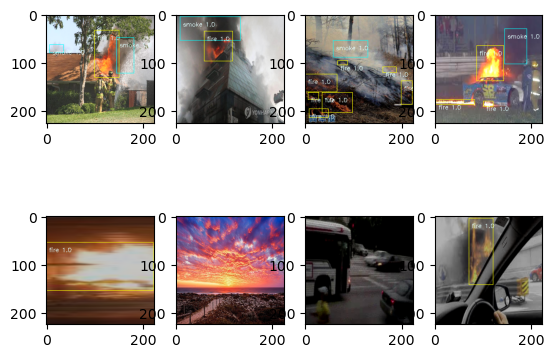

In [31]:
#for i, (img, label_mtx, img_path) in enumerate(view_loader):

plt.figure(figsize=(16, 6))

for i, (img, label_mtx) in enumerate(view_loader):
    #print(f'Batch id = {i}')

    plt.subplots(2,4)

    for idx in range(VIEW_BATCH_SIZE):
        #print(f'Index inside batch = {idx}')
        #print(img_path[idx])
        bboxes = get_bboxes_from_label_mtx(label_mtx[idx])
        #print(bboxes)
        img_ds = plot_pytorch(img[idx].permute(1, 2, 0), 
                              VIEW_IMG_W, 
                              VIEW_IMG_H, 
                              bboxes)
        plt.subplot(2, 4, idx+1)
        plt.imshow(img_ds)
        #plt.imshow(img[idx].permute(1, 2, 0))
        
        if (idx == 7):
            break
    #if (idx == 1):
    plt.tight_layout(w_pad=40)
    plt.show()
    break

# BED

In [32]:
class BED(nn.Module):
    def __init__(self, num_classes, S, B, in_channels=3):
        super(BED, self).__init__()
        self.in_channels = in_channels
        self.num_classes = num_classes
        self.S = S
        self.B = B
        
        self.model = self.__create_BED__()

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
            nn.MaxPool2d(kernel_size=2, stride=2), 
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock 7x7
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            # CNNBlock Out
            nn.Conv2d(64, 64, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, self.B*5 + self.num_classes, kernel_size=1, stride=1, padding=0,  bias=False),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
        
    def forward(self, x):
        x = self.model(x)
        class_softmax = torch.softmax(x[..., 5:7], dim=-1)
        out = torch.cat((torch.sigmoid(x[..., 0:5]), class_softmax), dim=-1)
        return out 

# Yolo Loss

In [33]:
class YoloLossMSE(nn.Module):
    '''
    Calculates Yolo V1 loss function, detailed in the paper

    Prediction format [xcell, ycell, w, h, confidence, class_0, class_1]
    Future update to 2 BB: [xcell, ycell, w, h, confidence_A, xcell, ycell, w, h, confidence_B, class_0, class_1]
    '''

    def __init__(self, SX, SY, B, C):
        super(YoloLossMSE, self).__init__()
        
        self.mse = nn.MSELoss(reduction="sum")

        self.SX = SX
        self.SY = SY
        self.B = B
        self.C = C

        self.lambda_coord = 5
        self.lambda_noobj = 0.5
        
        self.last_box_xy = 0.0
        self.last_box_wh = 0.0
        self.last_obj = 0.0
        self.last_noobj =0.0
        self.last_class = 0.0

    def forward(self, ground_truth, predictions):

        predictions = predictions.reshape(-1, self.SY, self.SX, self.B*5 + self.C)

        # =========================== #
        #        Exists Box?          #
        # =========================== #
        exists_box = ground_truth[..., 4:5]
        box_preds = exists_box*predictions[..., :4]
        box_target = exists_box*ground_truth[..., :4]

        # =============== #
        #   Center Loss   #
        # =============== #
        xy_loss = self.mse(box_preds[..., :2],
                           box_target[..., :2])
        self.last_box_xy = xy_loss.item()
        #print('\nCenter Loss', center_loss)

        # ====================== #
        #   Width, Height Loss   #
        # ====================== #
        # Use torch.sign to undo torch.abs and preserve gradient sign
        wh_pred = torch.sign(box_preds[..., 2:4])*torch.sqrt(torch.abs(box_preds[..., 2:4]) + 1e-6)
        wh_true = torch.sqrt(box_target[..., 2:4])
        wh_loss = self.mse(wh_pred,
                           wh_true)
        self.last_box_wh = wh_loss.item()
        #print('\nWidth and Height Loss',wh_loss)

        # =================== #
        #   Confidence Loss   #
        # =================== #
        # iou_batch = iou_tensor(boxes_labels=exists_box*ground_truth[...,:4], 
        #                        boxes_preds=exists_box*predictions[...,:4],
        #                        box_format='midpoint').squeeze()
        #print('\nIOU Batch', iou_batch)
        # confidence_loss = self.mse(iou_batch,
        #                            predictions[..., 4])
        #print('\nConfidence Loss', confidence_loss)
        ### WITHOU IOU
        confidence_loss = self.mse(exists_box*predictions[..., 4:5],
                                   exists_box*ground_truth[..., 4:5])
        self.last_obj = confidence_loss.item()

        # ================== #
        #   No Object Loss   #
        # ================== #
        noobj_loss = self.mse((1-exists_box)*predictions[..., 4:5],
                              (1-exists_box)*ground_truth[...,4:5])
        self.last_noobj = noobj_loss.item()
        #print('\nNo object Loss', noobj_loss)

        # ======================= #
        #   Classification Loss   #
        # ======================= #
        class_loss = self.mse(exists_box*predictions[..., 5:7],
                              exists_box*ground_truth[..., 5:7])
        #print('\nClassification Loss', class_loss)
        self.last_class = class_loss.item()

        # ============== #
        #   Total Loss   #
        # ============== #
        total_loss = (
            self.lambda_coord*(xy_loss + wh_loss)
            + confidence_loss
            + self.lambda_noobj*noobj_loss 
            + class_loss
        )

        return total_loss
    
    def get_last_losses(self):     
        return (
            5*self.last_box_xy,
            5*self.last_box_wh,
            self.last_obj,
            0.5*self.last_noobj,
            self.last_class
            )
    


# Train Loop Function

In [34]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}')
    
    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                        predictions=out)
        
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        # update progress bar
        #loop.set_postfix(loss=loss.item())
        #print(f'Partial Train Loss: {loss.item()}')

        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        train_mean_loss.append(train_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)

    train_mean_loss_out = sum(train_mean_loss)/len(train_mean_loss)
    print("\nTRAIN losses")
#     print(f"Mean total loss was {train_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print(f'{train_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))
    
    return (train_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return train_mean_loss_out


# Validation Loop Function

In [35]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_mean_loss = []
    mean_box_loss = []
    mean_confidence_loss = []
    mean_noobj_loss = []
    mean_class_loss = []

    for batch_idx, (x, y) in enumerate(loop):
#     for batch_idx, (x, y) in enumerate(loader):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)
#         loss = loss_fn.forward(ground_truth=y, 
#                                predictions=out)
        
        xy_loss, wh_loss, obj_loss, noobj_loss, class_loss = loss_fn.get_last_losses()
        # Appending each loss
        val_mean_loss.append(val_loss.item())
        box_loss = xy_loss + wh_loss
        mean_box_loss.append(box_loss)
        mean_confidence_loss.append(obj_loss)
        mean_noobj_loss.append(noobj_loss)
        mean_class_loss.append(class_loss)
        
        # update progress bar
        #loop.set_postfix(loss=loss.item())

    val_mean_loss_out = sum(val_mean_loss)/len(val_mean_loss)
    print("\nVAL losses")
#     print(f"Mean total loss was {val_mean_loss_out:.3f}") # TQDM prints last batch loss
    mean_box_loss_out = sum(mean_box_loss)/len(mean_box_loss)
    mean_confidence_loss_out = sum(mean_confidence_loss)/len(mean_confidence_loss)
    mean_noobj_loss_out = sum(mean_noobj_loss)/len(mean_noobj_loss)
    mean_class_loss_out = sum(mean_class_loss)/len(mean_class_loss)  
#     print(f"Mean box loss was {mean_box_loss_out:.3f}") 
#     print(f"Mean confidence loss was {mean_confidence_loss_out:.3f}") 
#     print(f"Mean noobj loss was {mean_noobj_loss_out:.3f}") 
#     print(f"Mean class loss was {mean_class_loss_out:.3f}") 

    print("Total Loss".ljust(12) + "|" + 
          "Box Loss".ljust(12) + "|" + 
          "Conf Loss".ljust(12) + "|" + 
          "No Obj Loss".ljust(12) + "|" + 
          "Class Loss".ljust(12))
    print(f'{val_mean_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_box_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_confidence_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_noobj_loss_out:.3f}'.ljust(12) + "|" +
          f'{mean_class_loss_out:.3f}'.ljust(12))

    return (val_mean_loss_out, 
            mean_box_loss_out, 
            mean_confidence_loss_out, 
            mean_noobj_loss_out, 
            mean_class_loss_out)
    
#     return val_loss_out

# Hyperparameters and Config

In [36]:
''' ============================
    Hyperparameters and More
============================ '''

LEARNING_RATE = 5e-4
#LEARNING_RATE = 1e-1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 64 
#WEIGHT_DECAY = 5e-4
WEIGHT_DECAY = 0
EPOCHS = 220
NUM_WORKERS = 2
PIN_MEMORY = True
#LOAD_MODEL = False
#LOAD_MODEL_FILE = "overfit.pth.tar"

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
EVAL_IMG_DIR = val_imgs
EVAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

IOU_THRES = 0.5
THRESHOLD = 0.1

''' ============================
    Configuration
============================ '''
IMG_W = IMG_DIM['W']
IMG_H = IMG_DIM['H']

CELL_SIZE_X = 1/SX
CELL_SIZE_Y = 1/SY


''' ============================
    Metrics
============================ '''
# mAP output
## Train
train_mAP = []
train_class_AP = []
train_class_precision = []
train_class_recall = []
## Val
val_mAP = []
val_class_AP = []
val_class_precision = []
val_class_recall = []

# Loss output
## Train
train_total_loss = []
train_box_loss = []
train_confidence_loss = []
train_noobj_loss = []
train_class_loss = []
## Val
val_total_loss = []
val_box_loss = []
val_confidence_loss = []
val_noobj_loss = []
val_class_loss = []

# Main Function

In [37]:
def main():

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    print(f'SX: {SX}\nSY: {SY}\nB: {B}\nC: {C}')
    print(f'Cell size:\n\tx = {CELL_SIZE_X}\n\ty = {CELL_SIZE_Y}')


    ''' ============================
        Cell to Box Mask
    ============================ '''
    cell2box_mask = torch.zeros((SY, SX, 2))
    for i in range(SY):
        for j in range(SX):
            cell2box_mask[i,j,0] = j
            cell2box_mask[i,j,1] = i    
#     print(cell2box_mask)
#     print("\n")

    ''' ======================================
        SETUP: Model, Loss, Dataset, Loader
    ====================================== '''
    if IMG_W == 88:
        print("Using Tinyssimo 88x88")
        #model_tynss = Tinyssimo_fixed_88x88(num_classes=C).to(DEVICE)
        model_tynss = Tinyssimo_fixed_88x88_BatchNorm(num_classes=C).to(DEVICE)
        #model_tynss = Tinyssimo_fixed_88x88_NANO(num_classes=C).to(DEVICE)
    elif IMG_W == 448:
        print("Using Tinyssimo 448x448")
        model_tynss = Tinyssimo_fixed_448x448(num_classes=C).to(DEVICE)
    elif IMG_W == 224:
        print("Using BED 224x224")
        model_tynss = BED(num_classes = C,
                          S = SX,
                          B = 1,
                          in_channels = 3).to(DEVICE)
    else:
        print("Using Tinyssimo 160x120")
        model_tynss = Tinyssimo_fixed_160x120(num_classes=C).to(DEVICE)
    
    model_tynss._initialize_weights()
    
    optimizer = optim.Adam(model_tynss.parameters(), 
                           lr=LEARNING_RATE, 
                           weight_decay=WEIGHT_DECAY)
    
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                     mode='min',
                                                     factor=0.9, 
                                                     patience=2, 
                                                     threshold=0.1, 
                                                     threshold_mode='abs',
                                                     min_lr=1e-5)
    
#     optimizer = torch.optim.SGD(model_tynss.parameters(), 
#                                 lr=LEARNING_RATE,
#                                 momentum=0.9, 
#                                 weight_decay=WEIGHT_DECAY, 
#                                 nesterov=True)
    
    n_trainable = sum(p.numel() for p in model_tynss.parameters() if p.requires_grad)
    print(f'\nTrainable parameters = {n_trainable}')

    n_params = parameters_to_vector(model_tynss.parameters()).numel()
    print(f'Total parameters = {n_params}\n')
    
    if B == 1:
        print(f'Using YoloLossMSE')
        loss_fn = YoloLossMSE(SX=SX, 
                              SY=SY, 
                              B=B, 
                              C=C)
    elif B == 2:
        print(f'Using YoloLossMSE_2BBox')
        loss_fn = YoloLossMSE_2BBox(SX=SX, 
                                    SY=SY, 
                                    B=B, 
                                    C=C)
    else:
        print("Wrong B bounding boxes configuration")

    train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        # If boxes are to close, it can remove some because they fall inside same cell
        A.RandomSizedBBoxSafeCrop(height=int(1.4*IMG_H),
                                  width= int(1.4*IMG_W),
                                  erosion_rate=0.6,
                                  p=0.3),
        A.HueSaturationValue(hue_shift_limit=10, p=0.2),
        A.Blur(blur_limit=(3,3), p=0.2),
        A.CLAHE(clip_limit=2.0, p=0.3),
            # Shifting, scaling and rotation could dive 2 bbox inside same grid...
            #A.ShiftScaleRotate(rotate_limit=10, p=0.2),
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', 
                                min_area=8*8, 
                                min_visibility=0.05, 
                                label_fields=['class_labels']))
    # TRAIN
    print("\nTRAIN DFIRE dataset")
    train_dataset = DFireDataset(img_h = IMG_H,
                                 img_w = IMG_W,
                                 img_dir = TRAIN_IMG_DIR,
                                 label_dir = TRAIN_LABEL_DIR,
                                 SX = SX,
                                 SY = SY,
                                 C = C,
                                 transform=train_transform)
    
    print("TRAIN DFS dataset")
    train_dfs_dataset = DFSDataset(img_h = IMG_H,
                                   img_w = IMG_W,
                                   img_dir = dfs_images_dir,
                                   labels_list = dfs_train_list,
                                   SX = SX,
                                   SY = SY,
                                   C = C,
                                   transform=train_transform)

    print("Concatenate Train DFire and DFS datasets")
    full_train_ds = torch.utils.data.ConcatDataset((train_dataset, train_dfs_dataset))
    print(f'Train dataset len: {len(full_train_ds)}')

    
    # VALIDATION
    val_transform = A.Compose([
        A.Resize(IMG_H, IMG_W, p=1),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
    
    print("\nTEST DFire dataset")
    eval_dataset = DFireDataset(img_h = IMG_H,
                                img_w = IMG_W,
                                img_dir = EVAL_IMG_DIR,
                                label_dir = EVAL_LABEL_DIR,
                                SX = SX,
                                SY = SY,
                                C = C,
                                transform=val_transform)
    print("TEST DFS dataset")
    test_dfs_dataset = DFSDataset(img_h = IMG_H,
                                  img_w = IMG_W,
                                  img_dir = dfs_images_dir,
                                  labels_list = dfs_test_list,
                                  SX = SX,
                                  SY = SY,
                                  C = C,
                                  transform=val_transform)
    
    print("Concatenate Test DFire and DFS datasets")
    full_test_ds = torch.utils.data.ConcatDataset((eval_dataset, test_dfs_dataset))
    print(f'Test dataset len: {len(full_test_ds)}')
    
    # LOADERS
    train_loader = DataLoader(dataset=full_train_ds,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              pin_memory=PIN_MEMORY,
                              shuffle=True,
                              drop_last=True)

    eval_loader = DataLoader(dataset=full_test_ds,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             pin_memory=PIN_MEMORY,
                             shuffle=False,
                             drop_last=True)


    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    
    for epoch in range(EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===\n')
        
        # TRAINING
        t_loss, b_loss, conf_loss, n_loss, cls_loss = train_fn(loader=train_loader, 
                                                               model=model_tynss, 
                                                               optimizer=optimizer, 
                                                               loss_fn=loss_fn,
                                                               device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(t_loss)
        train_box_loss.append(b_loss)
        train_confidence_loss.append(conf_loss)
        train_noobj_loss.append(n_loss)
        train_class_loss.append(cls_loss)
        
        ##### NO LOGS, ONLY TOTAL LOSS
#         t_loss = train_fn(loader=train_loader, 
#                           model=model_tynss, 
#                           optimizer=optimizer, 
#                           loss_fn=loss_fn,
#                           device=DEVICE)
#         # Appending Train Losses
#         train_total_loss.append(t_loss)


        # TRAIN MEAN AVERAGE PRECISION
        if ( (epoch+1) % 15 ) == 0:
            pred_boxes, target_boxes = get_bboxes(loader=train_loader, 
                                                  model=model_tynss,
                                                  SX=SX,
                                                  SY=SY,
                                                  B=B,
                                                  C=C,
                                                  mask=cell2box_mask,
                                                  iou_threshold=IOU_THRES, 
                                                  threshold=THRESHOLD,
                                                  device=DEVICE,
                                                  box_format="midpoint")

            mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                             true_boxes=target_boxes, 
                                                             iou_threshold=IOU_THRES, 
                                                             box_format="midpoint",
                                                             num_classes=C)

            train_mAP.append(mean_avg_prec)
            train_class_AP.append(avg_prec)   
            train_class_precision.append(cls_prec)
            train_class_recall.append(cls_rec)
            print(f"\nTrain mAP: {mean_avg_prec}")
        
        # VALIDATING
        with torch.no_grad():
            v_loss, b_loss, conf_loss, n_loss, cls_loss = eval_fn(loader=eval_loader, 
                                                                  model=model_tynss,                         
                                                                  loss_fn=loss_fn,
                                                                  device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(v_loss)
            val_box_loss.append(b_loss)
            val_confidence_loss.append(conf_loss)
            val_noobj_loss.append(n_loss)
            val_class_loss.append(cls_loss)
            
            scheduler.step(v_loss)
            
            ##### NO LOGS, ONLY TOTAL LOSS
#             v_loss = eval_fn(loader=eval_loader, 
#                              model=model_tynss,                         
#                              loss_fn=loss_fn,
#                              device=DEVICE)
#             # Appending Validation Losses
#             val_total_loss.append(v_loss)

            # VALIDATION MEAN AVERAGE PRECISION
            if ( (epoch+1) % 15 ) == 0:
                pred_boxes, target_boxes = get_bboxes(loader=eval_loader, 
                                                      model=model_tynss,
                                                      SX=SX,
                                                      SY=SY,
                                                      B=B,
                                                      C=C,
                                                      mask=cell2box_mask,
                                                      iou_threshold=IOU_THRES, 
                                                      threshold=THRESHOLD,
                                                      device=DEVICE,
                                                      box_format="midpoint")

                mean_avg_prec, avg_prec, cls_prec, cls_rec = mAP(pred_boxes=pred_boxes, 
                                                                 true_boxes=target_boxes, 
                                                                 iou_threshold=IOU_THRES, 
                                                                 box_format="midpoint",
                                                                 num_classes=C)

                val_mAP.append(mean_avg_prec)
                val_class_AP.append(avg_prec)   
                val_class_precision.append(cls_prec)
                val_class_recall.append(cls_rec)
                print(f"\nValidation mAP: {mean_avg_prec}")

        if best_valid_loss > v_loss:
            best_valid_loss = v_loss
            print(f"\nNew best validation loss: {best_valid_loss:.3f}")
            print('Saving best model...')
            torch.save(model_tynss.state_dict(), 'best.pt')   
            
    torch.save(model_tynss.state_dict(), 'last.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')

# Main Execute

In [39]:
if __name__ == "__main__":
    print("Starting script\n")
    #print(torch.cuda.is_available())
    main()

Starting script

Device: cuda
Learning Rate: 0.0005
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
SX: 7
SY: 7
B: 1
C: 2
Cell size:
	x = 0.14285714285714285
	y = 0.14285714285714285
Using BED 224x224


/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(



Trainable parameters = 295344
Total parameters = 295344

Using YoloLossMSE

TRAIN DFIRE dataset
Removed wrong images: 0
Removed due to overlapping: 1350
TRAIN DFS dataset
Removed wrong images: 0
Removed due to overlapping: 299
Concatenate Train DFire and DFS datasets
Train dataset len: 23141

TEST DFire dataset
Removed wrong images: 0
Removed due to overlapping: 322
TEST DFS dataset
Removed wrong images: 0
Removed due to overlapping: 47
Concatenate Test DFire and DFS datasets
Test dataset len: 5830

***Start Training: 20:39:02


=== EPOCH 0/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
317.465     |116.278     |48.022      |124.147     |29.018      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.90it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
233.288     |107.553     |56.315      |47.533      |21.887      

New best validation loss: 233.288
Saving best model...

=== EPOCH 1/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
211.084     |99.285      |57.245      |33.014      |21.540      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
198.501     |98.186      |60.644      |20.697      |18.975      

New best validation loss: 198.501
Saving best model...

=== EPOCH 2/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:16<00:00,  2.64it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
189.838     |93.319      |59.195      |18.429      |18.895      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.93it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
183.769     |92.368      |60.481      |14.480      |16.440      

New best validation loss: 183.769
Saving best model...

=== EPOCH 3/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
179.073     |88.833      |59.463      |13.603      |17.174      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.87it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
175.622     |87.754      |59.723      |13.037      |15.108      

New best validation loss: 175.622
Saving best model...

=== EPOCH 4/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:18<00:00,  2.61it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
170.895     |84.135      |59.541      |11.223      |15.996      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.87it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
169.856     |85.243      |57.888      |12.867      |13.859      

New best validation loss: 169.856
Saving best model...

=== EPOCH 5/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.63it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
164.978     |80.685      |59.056      |10.300      |14.937      


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
162.753     |80.548      |57.110      |12.289      |12.806      

New best validation loss: 162.753
Saving best model...

=== EPOCH 6/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:20<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
160.738     |78.693      |58.565      |9.704       |13.776      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
162.069     |81.270      |57.972      |10.075      |12.752      

New best validation loss: 162.069
Saving best model...

=== EPOCH 7/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.63it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
158.292     |77.467      |58.044      |9.322       |13.459      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
158.813     |78.478      |58.724      |8.522       |13.088      

New best validation loss: 158.813
Saving best model...

=== EPOCH 8/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:15<00:00,  2.67it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
155.673     |76.477      |57.598      |8.970       |12.628      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.90it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
155.813     |77.335      |57.784      |8.717       |11.977      

New best validation loss: 155.813
Saving best model...

=== EPOCH 9/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:20<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
153.018     |75.199      |56.999      |8.875       |11.945      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.86it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
152.502     |76.148      |57.244      |8.287       |10.823      

New best validation loss: 152.502
Saving best model...

=== EPOCH 10/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:18<00:00,  2.61it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
151.191     |74.261      |56.342      |8.918       |11.670      


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.68it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
151.204     |75.648      |55.752      |8.898       |10.905      

New best validation loss: 151.204
Saving best model...

=== EPOCH 11/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:16<00:00,  2.64it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
148.892     |73.171      |55.220      |9.165       |11.336      


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.28it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
147.553     |73.387      |51.974      |12.046      |10.145      

New best validation loss: 147.553
Saving best model...

=== EPOCH 12/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:25<00:00,  2.48it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
147.586     |72.898      |54.380      |9.319       |10.990      


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.73it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
146.980     |73.468      |53.104      |9.692       |10.716      

New best validation loss: 146.980
Saving best model...

=== EPOCH 13/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:32<00:00,  2.37it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
145.598     |71.725      |53.478      |9.493       |10.901      


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.70it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
143.635     |71.722      |51.845      |10.203      |9.864       

New best validation loss: 143.635
Saving best model...

=== EPOCH 14/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
144.719     |71.347      |53.155      |9.454       |10.763      



mAP:@.5: 100%|██████████| 2/2 [02:08<00:00, 64.26s/it]



Train mAP: 0.0623822882771492


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
142.940     |71.226      |49.841      |11.948      |9.925       



mAP:@.5: 100%|██████████| 2/2 [00:14<00:00,  7.06s/it]



Validation mAP: 0.058786775916814804

New best validation loss: 142.940
Saving best model...

=== EPOCH 15/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
142.682     |70.306      |52.390      |9.717       |10.269      


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
141.590     |70.237      |55.493      |6.230       |9.630       

New best validation loss: 141.590
Saving best model...

=== EPOCH 16/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:16<00:00,  2.64it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
140.512     |69.092      |51.736      |9.696       |9.987       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.83it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
142.133     |70.205      |46.739      |13.811      |11.378      

=== EPOCH 17/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
139.819     |68.706      |51.002      |9.901       |10.210      


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.69it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
140.373     |70.293      |49.362      |11.613      |9.105       

New best validation loss: 140.373
Saving best model...

=== EPOCH 18/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
138.045     |67.802      |50.492      |9.985       |9.766       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.85it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
137.186     |68.221      |45.621      |14.066      |9.278       

New best validation loss: 137.186
Saving best model...

=== EPOCH 19/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
136.689     |67.173      |50.092      |10.033      |9.391       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
134.729     |67.063      |50.288      |8.475       |8.903       

New best validation loss: 134.729
Saving best model...

=== EPOCH 20/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:18<00:00,  2.61it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
134.708     |65.949      |49.231      |10.117      |9.411       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
134.881     |66.805      |45.459      |13.830      |8.787       

=== EPOCH 21/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:19<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
134.089     |65.660      |49.077      |10.134      |9.219       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
134.661     |66.544      |45.390      |12.776      |9.951       

New best validation loss: 134.661
Saving best model...

=== EPOCH 22/219 ===

Learning Rate = 0.0005


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
133.092     |65.122      |48.809      |10.156      |9.005       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
135.382     |66.807      |48.475      |9.481       |10.619      

=== EPOCH 23/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
131.631     |64.313      |48.130      |10.174      |9.015       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
131.614     |65.518      |49.123      |8.428       |8.545       

New best validation loss: 131.614
Saving best model...

=== EPOCH 24/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:17<00:00,  2.63it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
130.530     |63.747      |47.798      |10.316      |8.669       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.85it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
130.063     |64.768      |45.322      |11.774      |8.199       

New best validation loss: 130.063
Saving best model...

=== EPOCH 25/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:16<00:00,  2.64it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
129.970     |63.433      |47.548      |10.237      |8.752       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
130.053     |65.076      |45.759      |10.860      |8.357       

New best validation loss: 130.053
Saving best model...

=== EPOCH 26/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
128.457     |62.369      |47.182      |10.400      |8.506       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.88it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
129.099     |63.973      |46.438      |10.373      |8.314       

New best validation loss: 129.099
Saving best model...

=== EPOCH 27/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
128.334     |62.656      |46.810      |10.430      |8.438       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.83it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
127.940     |63.444      |44.944      |11.560      |7.992       

New best validation loss: 127.940
Saving best model...

=== EPOCH 28/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
127.352     |61.819      |46.932      |10.269      |8.332       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
127.660     |63.594      |42.900      |13.176      |7.989       

New best validation loss: 127.660
Saving best model...

=== EPOCH 29/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
126.524     |61.555      |46.488      |10.409      |8.072       



mAP:@.5: 100%|██████████| 2/2 [01:39<00:00, 49.97s/it]



Train mAP: 0.13139255344867706


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
129.388     |64.343      |46.804      |9.578       |8.663       



mAP:@.5: 100%|██████████| 2/2 [00:11<00:00,  5.62s/it]



Validation mAP: 0.11913527548313141

=== EPOCH 30/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
125.345     |60.971      |46.064      |10.375      |7.935       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
126.098     |62.543      |44.145      |11.100      |8.309       

New best validation loss: 126.098
Saving best model...

=== EPOCH 31/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:17<00:00,  2.62it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
124.816     |60.490      |45.895      |10.442      |7.990       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.86it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
126.195     |62.743      |45.471      |9.645       |8.336       

=== EPOCH 32/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:27<00:00,  2.45it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
123.707     |59.872      |45.484      |10.479      |7.872       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
126.256     |63.069      |43.724      |11.309      |8.153       

=== EPOCH 33/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:27<00:00,  2.45it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
123.245     |59.696      |45.183      |10.507      |7.858       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.88it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
124.332     |61.814      |46.112      |8.632       |7.774       

New best validation loss: 124.332
Saving best model...

=== EPOCH 34/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
122.336     |58.912      |45.044      |10.575      |7.806       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
124.254     |61.867      |42.942      |11.559      |7.886       

New best validation loss: 124.254
Saving best model...

=== EPOCH 35/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.543     |58.778      |44.646      |10.520      |7.599       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.34it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
125.469     |62.245      |39.646      |15.454      |8.125       

=== EPOCH 36/219 ===

Learning Rate = 0.00045000000000000004


Training: 100%|██████████| 361/361 [02:24<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.255     |58.680      |44.407      |10.609      |7.559       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.74it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
125.304     |62.437      |41.215      |13.980      |7.673       

=== EPOCH 37/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
120.406     |58.118      |44.057      |10.669      |7.562       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.33it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
122.922     |61.436      |44.379      |9.577       |7.531       

New best validation loss: 122.922
Saving best model...

=== EPOCH 38/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
119.205     |57.427      |43.703      |10.662      |7.413       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.91it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.900     |60.765      |42.552      |11.011      |7.571       

New best validation loss: 121.900
Saving best model...

=== EPOCH 39/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:26<00:00,  2.46it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.663     |57.296      |43.423      |10.615      |7.328       


Validating: 100%|██████████| 91/91 [00:25<00:00,  3.60it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.285     |60.424      |42.854      |10.253      |7.755       

New best validation loss: 121.285
Saving best model...

=== EPOCH 40/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.638     |57.311      |43.212      |10.801      |7.314       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.33it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.397     |60.701      |40.076      |12.781      |7.839       

=== EPOCH 41/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.128     |56.807      |43.126      |10.751      |7.444       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.86it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
120.288     |60.207      |40.232      |12.205      |7.644       

New best validation loss: 120.288
Saving best model...

=== EPOCH 42/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.006     |56.554      |42.705      |10.805      |6.942       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
120.407     |60.379      |41.947      |10.352      |7.729       

=== EPOCH 43/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
116.848     |56.427      |42.566      |10.708      |7.148       


Validating: 100%|██████████| 91/91 [00:28<00:00,  3.17it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
121.054     |60.928      |40.904      |11.558      |7.665       

=== EPOCH 44/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:25<00:00,  2.48it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
116.145     |55.965      |42.461      |10.697      |7.022       



mAP:@.5: 100%|██████████| 2/2 [02:05<00:00, 62.74s/it]



Train mAP: 0.17340731620788574


Validating: 100%|██████████| 91/91 [00:25<00:00,  3.62it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
119.773     |59.914      |37.548      |14.633      |7.679       



mAP:@.5: 100%|██████████| 2/2 [00:13<00:00,  6.88s/it]



Validation mAP: 0.152516171336174

New best validation loss: 119.773
Saving best model...

=== EPOCH 45/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:24<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.143     |55.664      |42.050      |10.753      |6.674       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.35it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
119.438     |59.624      |36.404      |15.957      |7.453       

New best validation loss: 119.438
Saving best model...

=== EPOCH 46/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.490     |55.690      |41.777      |10.840      |7.182       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.434     |59.331      |40.018      |11.577      |7.508       

New best validation loss: 118.434
Saving best model...

=== EPOCH 47/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.588     |55.246      |41.633      |10.754      |6.955       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
119.957     |59.846      |37.481      |15.023      |7.606       

=== EPOCH 48/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.599     |54.809      |41.308      |10.801      |6.680       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.31it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.670     |59.704      |39.581      |11.822      |7.563       

=== EPOCH 49/219 ===

Learning Rate = 0.00040500000000000003


Training: 100%|██████████| 361/361 [02:24<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.891     |54.709      |41.499      |10.853      |6.829       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.91it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.485     |59.753      |38.703      |12.466      |7.562       

=== EPOCH 50/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.048     |53.906      |40.872      |10.739      |6.531       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.89it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
118.666     |59.286      |40.111      |11.654      |7.615       

=== EPOCH 51/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.095     |54.082      |40.611      |10.805      |6.598       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.355     |59.351      |37.792      |12.831      |7.381       

New best validation loss: 117.355
Saving best model...

=== EPOCH 52/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.856     |53.615      |40.662      |10.854      |6.725       


Validating: 100%|██████████| 91/91 [00:26<00:00,  3.39it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.256     |58.961      |40.117      |10.865      |7.313       

New best validation loss: 117.256
Saving best model...

=== EPOCH 53/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.021     |53.124      |40.562      |10.826      |6.510       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.249     |58.996      |40.840      |10.151      |7.262       

New best validation loss: 117.249
Saving best model...

=== EPOCH 54/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.156     |53.391      |40.488      |10.811      |6.467       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.33it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
116.889     |59.258      |38.018      |12.409      |7.203       

New best validation loss: 116.889
Saving best model...

=== EPOCH 55/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.382     |52.958      |40.073      |10.743      |6.607       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.903     |58.224      |40.275      |10.188      |7.216       

New best validation loss: 115.903
Saving best model...

=== EPOCH 56/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.171     |52.884      |40.046      |10.787      |6.453       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
116.935     |59.063      |38.042      |12.370      |7.460       

=== EPOCH 57/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.039     |52.782      |40.052      |10.875      |6.330       


Validating: 100%|██████████| 91/91 [00:26<00:00,  3.42it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.111     |59.528      |39.557      |10.822      |7.204       

=== EPOCH 58/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.519     |52.539      |39.882      |10.751      |6.347       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.045     |58.090      |38.397      |11.362      |7.196       

New best validation loss: 115.045
Saving best model...

=== EPOCH 59/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.270     |52.287      |39.757      |10.855      |6.372       



mAP:@.5: 100%|██████████| 2/2 [01:56<00:00, 58.14s/it]



Train mAP: 0.1720355749130249


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.88it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
117.210     |58.443      |36.523      |14.088      |8.156       



mAP:@.5: 100%|██████████| 2/2 [00:13<00:00,  6.70s/it]



Validation mAP: 0.1501174122095108

=== EPOCH 60/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:25<00:00,  2.48it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
108.303     |51.766      |39.529      |10.718      |6.290       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.770     |58.305      |37.354      |12.706      |7.404       

=== EPOCH 61/219 ===

Learning Rate = 0.0003645


Training: 100%|██████████| 361/361 [02:25<00:00,  2.48it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.052     |52.623      |39.486      |10.753      |6.190       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.73it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
115.918     |58.872      |38.472      |11.402      |7.173       

=== EPOCH 62/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
107.490     |51.335      |39.433      |10.691      |6.031       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.209     |57.426      |38.610      |11.076      |7.098       

New best validation loss: 114.209
Saving best model...

=== EPOCH 63/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
106.238     |50.929      |38.737      |10.672      |5.899       


Validating: 100%|██████████| 91/91 [00:26<00:00,  3.37it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.139     |57.682      |38.420      |10.900      |7.137       

New best validation loss: 114.139
Saving best model...

=== EPOCH 64/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
106.927     |51.088      |39.151      |10.651      |6.037       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.528     |57.847      |38.938      |10.596      |7.146       

=== EPOCH 65/219 ===

Learning Rate = 0.00032805000000000003


Training: 100%|██████████| 361/361 [02:25<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
106.530     |51.108      |38.903      |10.567      |5.953       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.66it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.663     |57.547      |39.752      |10.168      |7.196       

=== EPOCH 66/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 361/361 [02:24<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
105.344     |50.270      |38.616      |10.673      |5.786       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.35it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.011     |56.899      |38.563      |10.456      |7.094       

New best validation loss: 113.011
Saving best model...

=== EPOCH 67/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 361/361 [02:26<00:00,  2.47it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
106.427     |50.840      |38.839      |10.587      |6.160       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.903     |57.467      |35.266      |14.083      |7.087       

=== EPOCH 68/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 361/361 [02:25<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
104.844     |50.006      |38.210      |10.677      |5.951       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.68it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.115     |57.628      |38.306      |10.620      |7.562       

=== EPOCH 69/219 ===

Learning Rate = 0.000295245


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
104.936     |50.236      |38.412      |10.690      |5.598       


Validating: 100%|██████████| 91/91 [00:29<00:00,  3.13it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
114.339     |58.164      |35.724      |13.400      |7.051       

=== EPOCH 70/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
103.768     |49.271      |38.141      |10.614      |5.743       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.86it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.943     |57.560      |36.763      |12.368      |7.251       

=== EPOCH 71/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 361/361 [02:25<00:00,  2.48it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
103.765     |49.518      |37.903      |10.660      |5.684       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.327     |57.435      |37.883      |10.661      |7.347       

=== EPOCH 72/219 ===

Learning Rate = 0.0002657205


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
103.080     |49.054      |37.564      |10.623      |5.838       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.32it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.583     |57.441      |38.480      |10.439      |7.224       

=== EPOCH 73/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 361/361 [02:24<00:00,  2.49it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
103.326     |49.133      |37.781      |10.600      |5.812       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.412     |56.930      |35.322      |13.364      |6.796       

New best validation loss: 112.412
Saving best model...

=== EPOCH 74/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
102.551     |48.612      |37.617      |10.650      |5.673       



mAP:@.5: 100%|██████████| 2/2 [01:45<00:00, 52.56s/it]



Train mAP: 0.2160811722278595


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.380     |56.826      |35.739      |12.706      |7.110       



mAP:@.5: 100%|██████████| 2/2 [00:11<00:00,  5.83s/it]



Validation mAP: 0.18374481797218323

New best validation loss: 112.380
Saving best model...

=== EPOCH 75/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
102.572     |48.631      |37.557      |10.658      |5.726       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.861     |57.323      |38.460      |10.670      |7.409       

=== EPOCH 76/219 ===

Learning Rate = 0.00023914845


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
101.756     |48.472      |37.465      |10.563      |5.255       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.27it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.574     |56.811      |36.336      |12.250      |7.178       

=== EPOCH 77/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
101.033     |48.049      |37.084      |10.619      |5.281       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.34it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.861     |56.852      |35.757      |13.001      |7.251       

=== EPOCH 78/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
101.753     |48.188      |37.340      |10.603      |5.622       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.978     |57.261      |35.896      |12.882      |6.940       

=== EPOCH 79/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:24<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
100.862     |47.989      |37.032      |10.508      |5.332       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.73it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.291     |57.013      |35.315      |13.092      |6.871       

New best validation loss: 112.291
Saving best model...

=== EPOCH 80/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
100.621     |47.741      |36.974      |10.605      |5.302       


Validating: 100%|██████████| 91/91 [00:26<00:00,  3.37it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.114     |56.727      |35.345      |12.834      |7.209       

New best validation loss: 112.114
Saving best model...

=== EPOCH 81/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
100.316     |47.617      |36.811      |10.540      |5.347       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.677     |56.785      |35.689      |12.383      |6.820       

New best validation loss: 111.677
Saving best model...

=== EPOCH 82/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
100.334     |47.676      |36.971      |10.434      |5.254       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
113.142     |57.165      |35.522      |12.632      |7.823       

=== EPOCH 83/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
99.944      |47.286      |36.891      |10.544      |5.224       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.34it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.182     |56.982      |34.972      |13.127      |7.102       

=== EPOCH 84/219 ===

Learning Rate = 0.000215233605


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
100.621     |47.880      |36.829      |10.523      |5.389       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.923     |57.394      |35.186      |13.178      |7.165       

=== EPOCH 85/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
99.716      |47.261      |36.886      |10.435      |5.134       


Validating: 100%|██████████| 91/91 [00:28<00:00,  3.17it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.743     |56.748      |37.645      |10.151      |7.198       

=== EPOCH 86/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 361/361 [02:26<00:00,  2.46it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
99.133      |46.871      |36.535      |10.476      |5.250       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.87it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
112.414     |57.384      |37.879      |10.025      |7.127       

=== EPOCH 87/219 ===

Learning Rate = 0.0001937102445


Training: 100%|██████████| 361/361 [02:23<00:00,  2.51it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
99.250      |47.055      |36.413      |10.586      |5.196       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.991     |57.060      |35.738      |12.046      |7.147       

=== EPOCH 88/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
98.703      |46.600      |36.700      |10.362      |5.041       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.27it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.148     |56.548      |36.587      |10.921      |7.092       

New best validation loss: 111.148
Saving best model...

=== EPOCH 89/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 361/361 [02:24<00:00,  2.50it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
98.082      |46.302      |36.156      |10.503      |5.121       



mAP:@.5: 100%|██████████| 2/2 [01:33<00:00, 46.81s/it]



Train mAP: 0.23132310807704926


Validating: 100%|██████████| 91/91 [00:22<00:00,  4.06it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.324     |56.703      |35.951      |11.681      |6.990       



mAP:@.5: 100%|██████████| 2/2 [00:12<00:00,  6.16s/it]



Validation mAP: 0.18896090984344482

=== EPOCH 90/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
97.751      |46.007      |36.247      |10.424      |5.073       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.71it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.738     |56.878      |35.593      |12.142      |7.124       

=== EPOCH 91/219 ===

Learning Rate = 0.00017433922005


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
98.096      |46.558      |36.169      |10.393      |4.976       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.74it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.530     |56.830      |36.980      |10.748      |6.972       

=== EPOCH 92/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
97.596      |45.811      |36.361      |10.435      |4.989       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.67it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.474     |56.847      |36.650      |10.898      |7.079       

=== EPOCH 93/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
96.843      |45.509      |35.894      |10.433      |5.007       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.764     |56.939      |35.680      |12.015      |7.130       

=== EPOCH 94/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
97.234      |45.589      |36.021      |10.482      |5.142       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.821     |56.420      |35.695      |11.783      |6.923       

New best validation loss: 110.821
Saving best model...

=== EPOCH 95/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:19<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
96.576      |45.335      |35.865      |10.306      |5.070       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.944     |57.148      |35.708      |11.985      |7.104       

=== EPOCH 96/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:19<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
96.813      |45.609      |35.794      |10.441      |4.969       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.810     |56.647      |37.021      |10.881      |7.261       

=== EPOCH 97/219 ===

Learning Rate = 0.00015690529804500002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
96.881      |45.523      |35.910      |10.451      |4.997       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.967     |56.316      |36.535      |10.956      |7.160       

=== EPOCH 98/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
96.482      |45.561      |35.660      |10.311      |4.951       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.69it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.828     |56.385      |36.926      |10.615      |6.901       

=== EPOCH 99/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
95.921      |44.972      |35.651      |10.354      |4.944       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.860     |56.515      |35.764      |11.534      |7.048       

=== EPOCH 100/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
95.742      |44.720      |35.629      |10.321      |5.072       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.076     |55.991      |35.975      |11.321      |6.789       

New best validation loss: 110.076
Saving best model...

=== EPOCH 101/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
95.902      |44.991      |35.665      |10.367      |4.879       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.70it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.869     |56.479      |35.707      |11.669      |7.014       

=== EPOCH 102/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
95.394      |44.654      |35.335      |10.431      |4.974       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.81it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.873     |56.648      |37.077      |10.324      |6.823       

=== EPOCH 103/219 ===

Learning Rate = 0.00014121476824050002


Training: 100%|██████████| 361/361 [02:19<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
94.752      |44.459      |35.242      |10.324      |4.727       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.525     |56.340      |35.405      |11.861      |6.919       

=== EPOCH 104/219 ===

Learning Rate = 0.00012709329141645002


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
94.762      |44.398      |35.241      |10.391      |4.732       



mAP:@.5: 100%|██████████| 2/2 [01:29<00:00, 44.95s/it]



Train mAP: 0.23658625781536102


Validating: 100%|██████████| 91/91 [00:22<00:00,  3.99it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.638     |56.433      |36.772      |10.424      |7.009       



mAP:@.5: 100%|██████████| 2/2 [00:09<00:00,  4.88s/it]



Validation mAP: 0.19008508324623108

=== EPOCH 105/219 ===

Learning Rate = 0.00012709329141645002


Training: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
95.303      |44.531      |35.344      |10.293      |5.135       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.953     |56.421      |36.447      |10.957      |7.128       

=== EPOCH 106/219 ===

Learning Rate = 0.00012709329141645002


Training: 100%|██████████| 361/361 [02:21<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
94.829      |44.514      |35.224      |10.172      |4.919       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.385     |56.841      |34.585      |13.000      |6.959       

=== EPOCH 107/219 ===

Learning Rate = 0.00011438396227480502


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
94.327      |44.211      |35.049      |10.290      |4.777       


Validating: 100%|██████████| 91/91 [00:27<00:00,  3.28it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.766     |56.695      |34.944      |12.297      |6.831       

=== EPOCH 108/219 ===

Learning Rate = 0.00011438396227480502


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
94.629      |44.291      |35.204      |10.338      |4.795       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.728     |56.631      |35.246      |12.006      |6.845       

=== EPOCH 109/219 ===

Learning Rate = 0.00011438396227480502


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.941      |44.189      |34.921      |10.257      |4.574       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.696     |56.594      |35.705      |11.492      |6.904       

=== EPOCH 110/219 ===

Learning Rate = 0.00010294556604732453


Training: 100%|██████████| 361/361 [02:21<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.362      |43.662      |34.925      |10.245      |4.530       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.70it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.533     |56.435      |36.016      |11.079      |7.003       

=== EPOCH 111/219 ===

Learning Rate = 0.00010294556604732453


Training: 100%|██████████| 361/361 [02:19<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.260      |43.563      |34.839      |10.225      |4.633       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.83it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.845     |56.627      |36.379      |10.875      |6.965       

=== EPOCH 112/219 ===

Learning Rate = 0.00010294556604732453


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.194      |43.388      |34.905      |10.283      |4.618       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
111.069     |56.768      |36.496      |10.613      |7.191       

=== EPOCH 113/219 ===

Learning Rate = 9.265100944259208e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.813      |44.058      |35.031      |10.183      |4.542       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.361     |56.311      |36.275      |10.898      |6.877       

=== EPOCH 114/219 ===

Learning Rate = 9.265100944259208e-05


Training: 100%|██████████| 361/361 [02:18<00:00,  2.61it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.024      |43.285      |34.912      |10.169      |4.658       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.625     |56.403      |35.338      |11.930      |6.953       

=== EPOCH 115/219 ===

Learning Rate = 9.265100944259208e-05


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.208      |43.567      |34.789      |10.218      |4.634       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.436     |56.366      |35.384      |11.676      |7.010       

=== EPOCH 116/219 ===

Learning Rate = 8.338590849833288e-05


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
93.113      |43.322      |34.812      |10.272      |4.708       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.72it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.081     |56.167      |35.033      |11.937      |6.945       

=== EPOCH 117/219 ===

Learning Rate = 8.338590849833288e-05


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.403      |43.288      |34.367      |10.275      |4.473       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.78it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.632     |56.447      |35.006      |12.093      |7.086       

=== EPOCH 118/219 ===

Learning Rate = 8.338590849833288e-05


Training: 100%|██████████| 361/361 [02:19<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.547      |43.261      |34.662      |10.126      |4.498       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.438     |56.552      |34.457      |12.604      |6.826       

=== EPOCH 119/219 ===

Learning Rate = 7.50473176484996e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.091      |43.054      |34.471      |10.209      |4.358       



mAP:@.5: 100%|██████████| 2/2 [01:31<00:00, 45.72s/it]



Train mAP: 0.2509464621543884


Validating: 100%|██████████| 91/91 [00:22<00:00,  3.97it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.187     |56.221      |35.491      |11.410      |7.065       



mAP:@.5: 100%|██████████| 2/2 [00:10<00:00,  5.09s/it]



Validation mAP: 0.19688734412193298

=== EPOCH 120/219 ===

Learning Rate = 7.50473176484996e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.038      |42.738      |34.495      |10.199      |4.606       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.757     |56.058      |34.179      |12.746      |6.775       

New best validation loss: 109.757
Saving best model...

=== EPOCH 121/219 ===

Learning Rate = 7.50473176484996e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.039      |42.767      |34.618      |10.219      |4.434       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.84it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.224     |56.249      |34.787      |12.186      |7.001       

=== EPOCH 122/219 ===

Learning Rate = 7.50473176484996e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.515      |43.161      |34.468      |10.311      |4.576       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.148     |56.400      |35.733      |11.122      |6.894       

=== EPOCH 123/219 ===

Learning Rate = 7.50473176484996e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.645      |42.463      |34.447      |10.194      |4.540       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.081     |56.173      |35.823      |11.151      |6.933       

=== EPOCH 124/219 ===

Learning Rate = 6.754258588364964e-05


Training: 100%|██████████| 361/361 [02:19<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.577      |43.161      |34.656      |10.081      |4.680       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.70it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.265     |56.352      |35.235      |11.718      |6.959       

=== EPOCH 125/219 ===

Learning Rate = 6.754258588364964e-05


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
92.419      |43.022      |34.585      |10.133      |4.678       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.85it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.133     |56.138      |35.538      |11.448      |7.009       

=== EPOCH 126/219 ===

Learning Rate = 6.754258588364964e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.331      |42.619      |34.147      |10.177      |4.387       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.83it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.628     |56.508      |34.656      |12.485      |6.978       

=== EPOCH 127/219 ===

Learning Rate = 6.078832729528468e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.455      |42.463      |34.399      |10.128      |4.465       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.443     |56.517      |35.936      |11.003      |6.988       

=== EPOCH 128/219 ===

Learning Rate = 6.078832729528468e-05


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.597      |42.469      |34.452      |10.208      |4.468       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.097     |56.191      |35.575      |11.379      |6.952       

=== EPOCH 129/219 ===

Learning Rate = 6.078832729528468e-05


Training: 100%|██████████| 361/361 [02:22<00:00,  2.53it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.818      |42.138      |34.149      |10.111      |4.419       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.80it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.645     |56.671      |35.465      |11.552      |6.957       

=== EPOCH 130/219 ===

Learning Rate = 5.4709494565756215e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.456      |42.642      |34.207      |10.126      |4.480       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.70it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.208     |56.370      |35.448      |11.493      |6.897       

=== EPOCH 131/219 ===

Learning Rate = 5.4709494565756215e-05


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.003      |42.277      |34.230      |9.993       |4.503       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.209     |56.336      |34.980      |11.923      |6.970       

=== EPOCH 132/219 ===

Learning Rate = 5.4709494565756215e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.757      |41.994      |34.274      |10.025      |4.464       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.166     |56.392      |35.436      |11.476      |6.862       

=== EPOCH 133/219 ===

Learning Rate = 4.923854510918059e-05


Training: 100%|██████████| 361/361 [02:22<00:00,  2.54it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.049      |42.324      |34.277      |10.106      |4.342       


Validating: 100%|██████████| 91/91 [00:25<00:00,  3.58it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.140     |56.390      |35.836      |11.012      |6.902       

=== EPOCH 134/219 ===

Learning Rate = 4.923854510918059e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]


TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.944      |42.103      |34.269      |10.098      |4.474       



mAP:@.5: 100%|██████████| 2/2 [01:26<00:00, 43.49s/it]



Train mAP: 0.2569785714149475


Validating: 100%|██████████| 91/91 [00:22<00:00,  4.01it/s]


VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.112     |56.248      |35.783      |11.083      |6.998       



mAP:@.5: 100%|██████████| 2/2 [00:09<00:00,  4.92s/it]



Validation mAP: 0.20210860669612885

=== EPOCH 135/219 ===

Learning Rate = 4.923854510918059e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.122      |42.337      |34.365      |10.002      |4.418       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.71it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.621     |56.819      |34.887      |12.034      |6.881       

=== EPOCH 136/219 ===

Learning Rate = 4.431469059826253e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.327      |41.989      |34.045      |9.978       |4.315       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.85it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.225     |56.351      |35.014      |11.784      |7.075       

=== EPOCH 137/219 ===

Learning Rate = 4.431469059826253e-05


Training: 100%|██████████| 361/361 [02:19<00:00,  2.59it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.925      |42.302      |34.064      |10.118      |4.442       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.69it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.375     |56.481      |36.327      |10.622      |6.945       

=== EPOCH 138/219 ===

Learning Rate = 4.431469059826253e-05


Training: 100%|██████████| 361/361 [02:18<00:00,  2.61it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.600      |41.991      |34.231      |10.020      |4.358       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.211     |56.352      |35.391      |11.542      |6.926       

=== EPOCH 139/219 ===

Learning Rate = 3.988322153843628e-05


Training: 100%|██████████| 361/361 [02:19<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.615      |42.056      |34.345      |9.894       |4.320       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.83it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.219     |56.472      |35.569      |11.221      |6.957       

=== EPOCH 140/219 ===

Learning Rate = 3.988322153843628e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.56it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.309      |41.744      |33.993      |10.145      |4.427       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.230     |56.462      |35.139      |11.779      |6.849       

=== EPOCH 141/219 ===

Learning Rate = 3.988322153843628e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.717      |42.108      |34.203      |9.967       |4.440       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.74it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.030     |56.295      |35.680      |11.185      |6.870       

=== EPOCH 142/219 ===

Learning Rate = 3.589489938459265e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.58it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
91.220      |42.403      |34.225      |10.086      |4.505       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.76it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.089     |56.490      |35.216      |11.587      |6.796       

=== EPOCH 143/219 ===

Learning Rate = 3.589489938459265e-05


Training: 100%|██████████| 361/361 [02:18<00:00,  2.60it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.357      |41.932      |34.022      |9.992       |4.413       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.77it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.208     |56.398      |34.699      |12.136      |6.974       

=== EPOCH 144/219 ===

Learning Rate = 3.589489938459265e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.191      |41.662      |33.977      |10.157      |4.395       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.69it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.300     |56.465      |35.435      |11.454      |6.946       

=== EPOCH 145/219 ===

Learning Rate = 3.230540944613339e-05


Training: 100%|██████████| 361/361 [02:20<00:00,  2.57it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.016      |41.760      |33.973      |10.074      |4.209       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.79it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.881     |56.267      |35.571      |11.152      |6.892       

=== EPOCH 146/219 ===

Learning Rate = 3.230540944613339e-05


Training: 100%|██████████| 361/361 [02:21<00:00,  2.55it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
90.565      |42.035      |34.107      |10.037      |4.386       


Validating: 100%|██████████| 91/91 [00:23<00:00,  3.82it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
109.929     |56.314      |35.070      |11.606      |6.939       

=== EPOCH 147/219 ===

Learning Rate = 3.230540944613339e-05


Training: 100%|██████████| 361/361 [02:23<00:00,  2.52it/s]



TRAIN losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
89.740      |41.281      |34.135      |9.964       |4.360       


Validating: 100%|██████████| 91/91 [00:24<00:00,  3.75it/s]



VAL losses
Total Loss  |Box Loss    |Conf Loss   |No Obj Loss |Class Loss  
110.445     |56.671      |34.882      |11.938      |6.954       

=== EPOCH 148/219 ===

Learning Rate = 2.907486850152005e-05


Training:  72%|███████▏  | 259/361 [01:43<00:40,  2.51it/s]


KeyboardInterrupt: 